In [1]:
import pathlib
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.callbacks import *
from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
import scikitplot as skplt

import matplotlib.pyplot as plt

In [2]:
data_dir = pathlib.Path('/kaggle/input/flowers-recognition/flowers')

```
p = Augmentor.Pipeline(data_dir,output_directory="/kaggle/working/")
#Step 3 Define the Operations
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p.sample(12000)
```

In [3]:
train_gen = ImageDataGenerator(rescale = 1./255,shear_range=.2,zoom_range=.2, horizontal_flip=True)
test_gen = ImageDataGenerator(rescale = 1./255, shear_range=.2, zoom_range=.2, horizontal_flip=True)

In [4]:
train_ds  = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(224,224),
  batch_size=32
)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [5]:
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(224,224),
  batch_size=32
)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [6]:
normalization_layer = Rescaling(1./255)

In [7]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [8]:
AUTOTUNE = AUTOTUNE
train_ds = train_ds.cache().shuffle(12000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ResNet 50

```
base_model = ResNet50(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)


# Freeze the first 10 layers
for layer in base_model.layers[:10]:
    layer.trainable = False
    
    
x = base_model.output
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(5, activation='softmax')(x)


model1 = Model(inputs=base_model.inputs, outputs=predictions)
```

```
RLROP_PATIENCE = 4
DECAY_DROP = 0.5
path = "/kaggle/working/ResNet50.h5"
es_re = EarlyStopping(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, restore_best_weights=True, verbose=1)
rlrop_re = ReduceLROnPlateau(monitor='val_acc', mode='auto', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
checkpoint_re = ModelCheckpoint(filepath=path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
```

```
model1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])
```

```
history_res = model1.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 100,callbacks=[es_re,rlrop_re, checkpoint_re])
```

# Confution Matrix and Classification Report for **ResNet50**

```
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)
```

```
Y_pred = model1.predict(val_ds,verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
#target_names = ['Normal','Glocoman']
print(classification_report(test_label, y_pred, target_names=target_names))
```

```
sns.heatmap(cm/np.sum(cm), annot = True, fmt='.2%', cmap = "Blues")
```

```
acc = history_res.history['accuracy']
val_acc = history_res.history['val_accuracy']
loss = history_res.history['loss']
val_loss = history_res.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy using ResNet50')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
```

# DenseNet 201

In [9]:
densenet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model_den = Sequential(name ="Dense_Seq")
model_den.add(densenet)
model_den.add(GlobalAveragePooling2D())
model_den.add(Dense(256, activation='relu'))
model_den.add(Dropout(0.5))
model_den.add(Dense(128, activation='relu'))
model_den.add(Dropout(0.5))
model_den.add(Dense(5, activation='softmax'))

74836368/74836368 [==============================] - 3s 0us/step


```
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
path = "/kaggle/working/Dense.h5"
es_d = EarlyStopping(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, restore_best_weights=True, verbose=1)
rlrop_d = ReduceLROnPlateau(monitor='val_acc', mode='auto', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
checkpoint_d = ModelCheckpoint(filepath=path, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
```

In [10]:
model_den.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

```
hist1 = model_den.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 100,callbacks=[checkpoint_d,rlrop_d, es_d])
```

```
acc = hist1.history['accuracy']
val_acc = hist1.history['val_accuracy']
loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy using DenseNet201')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss DenseNet201')
plt.legend()

plt.show()
```

```
Y_pred = model_den.predict(val_ds, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
```

```
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)
```

```
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
#target_names = ['Normal','Glocoman']
print(classification_report(test_label, y_pred, target_names=target_names))

sns.heatmap(cm/np.sum(cm), annot = True, fmt='.2%', cmap = "Blues")
```

# EfficientNetB7

In [11]:
eff = EfficientNetB7(include_top = False,weights = 'imagenet',input_shape = (224,224,3))

for layer in eff.layers[:748]:
    layer.trainable = False
    
model_eff = Sequential(name ="Eff_Seq")
model_eff.add(eff)
model_eff.add(GlobalAveragePooling2D())
model_eff.add(Dense(256, activation='relu'))
model_eff.add(Dropout(0.5))
model_eff.add(Dense(128, activation='relu'))
model_eff.add(Dropout(0.5))
model_eff.add(Dense(5, activation='softmax'))

258076736/258076736 [==============================] - 8s 0us/step


In [12]:
model_eff.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

```
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
path_e = "/kaggle/working/Eff.h5"
es_e = EarlyStopping(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, restore_best_weights=True, verbose=1)
rlrop_e = ReduceLROnPlateau(monitor='val_acc', mode='auto', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
checkpoint_e = ModelCheckpoint(filepath=path_e, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
```

```
hist2 = model_eff.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 100,callbacks=[checkpoint_e,rlrop_e, es_e])
```

```
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy using EfficientNetB7')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss EfficientNetB7')
plt.legend()

plt.show()
```

# InceptionV3

```
base_model2 = InceptionV3(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)


# Freeze the first 10 layers
for layer in base_model2.layers[:10]:
    layer.trainable = False
    
    
x = base_model2.output
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)


model3 = Model(inputs=base_model2.inputs, outputs=predictions)
```

```
model3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])
```

```
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
es_i = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)
rlrop_i = ReduceLROnPlateau(monitor='val_acc', mode='auto', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
checkpoint_i = ModelCheckpoint("/kaggle/working/models/InceptionV3.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
```

```
hist3 = model3.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 100,callbacks=[es_i, rlrop_i, checkpoint_i])
```

```
acc = hist3.history['accuracy']
val_acc = hist3.history['val_accuracy']
loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy using InceptionV3')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss InceptionV3')
plt.legend()

plt.show()
```

# Ensemble Learning

In [13]:
from tensorflow.keras.models import load_model

In [14]:
# model_1 = load_model('/kaggle/working/models/DenseNet201.h5')

models = [model_den,model_eff]
model_input = tf.keras.Input(shape=(224,224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [15]:
RLROP_PATIENCE = 5
DECAY_DROP = 0.5
path = "/kaggle/working/Ensemble.h5"
es = EarlyStopping(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_acc', mode='auto', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(filepath=path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [16]:
ensemble_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

In [17]:
from tensorflow.keras.utils import plot_model

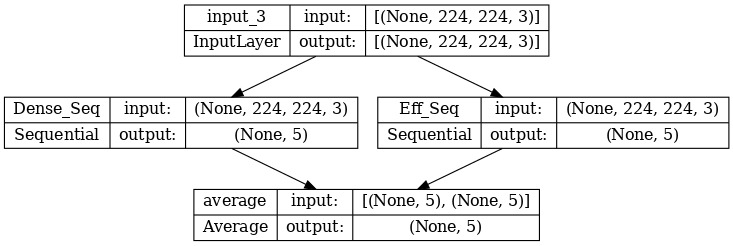

In [18]:
plot_model(ensemble_model, 'model.png', show_shapes= True, dpi=80)

In [19]:
hist = ensemble_model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 100,
                    callbacks=[checkpoint,rlrop, es])

Epoch 1/100


2023-02-28 17:02:35.827001: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inensemble/Eff_Seq/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


108/108 [==============================] - 259s 853ms/step - loss: 1.1825 - accuracy: 0.5782 - val_loss: 0.6074 - val_accuracy: 0.8946 - lr: 5.0000e-05
Epoch 2/100
108/108 [==============================] - 77s 715ms/step - loss: 0.5888 - accuracy: 0.8605 - val_loss: 0.3131 - val_accuracy: 0.9293 - lr: 5.0000e-05
Epoch 3/100
108/108 [==============================] - 77s 714ms/step - loss: 0.3146 - accuracy: 0.9363 - val_loss: 0.2166 - val_accuracy: 0.9340 - lr: 5.0000e-05
Epoch 4/100
108/108 [==============================] - 77s 715ms/step - loss: 0.1900 - accuracy: 0.9667 - val_loss: 0.1826 - val_accuracy: 0.9374 - lr: 5.0000e-05
Epoch 5/100
108/108 [==============================] - 77s 715ms/step - loss: 0.1145 - accuracy: 0.9792 - val_loss: 0.1722 - val_accuracy: 0.9455 - lr: 5.0000e-05
Epoch 6/100
108/108 [==============================] - 77s 717ms/step - loss: 0.0825 - accuracy: 0.9864 - val_loss: 0.1711 - val_accuracy: 0.9421 - lr: 5.0000e-05
Epoch 7/100
108/108 [============

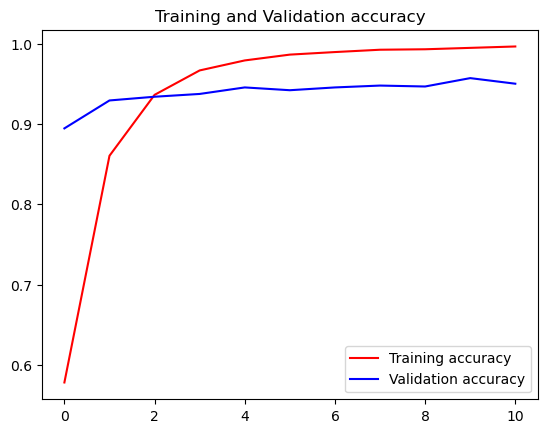

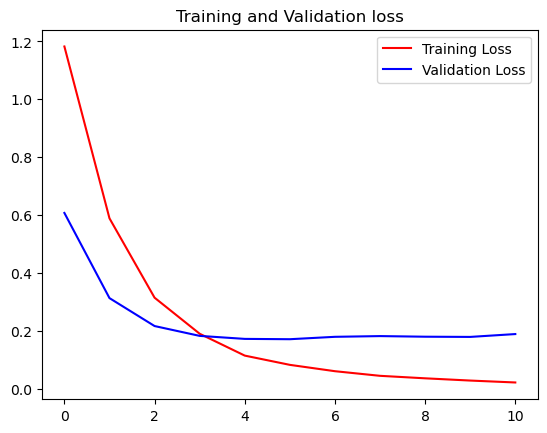

In [20]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [21]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(3454,)
(863,)


# Confution Matrix and Classification Report

In [22]:
Y_pred = ensemble_model.predict(val_ds, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

27/27 [==============================] - 17s 300ms/step


Confusion Matrix
[[131   7   3   2   1]
 [  2 197   0   3   4]
 [  1   1 124   0  11]
 [  0   0   2 167   3]
 [  0   1   9   0 194]]
Classification Report
              precision    recall  f1-score   support

   dandelion       0.98      0.91      0.94       144
       daisy       0.96      0.96      0.96       206
   sunflower       0.90      0.91      0.90       137
       tulip       0.97      0.97      0.97       172
        rose       0.91      0.95      0.93       204

    accuracy                           0.94       863
   macro avg       0.94      0.94      0.94       863
weighted avg       0.94      0.94      0.94       863



<AxesSubplot:>

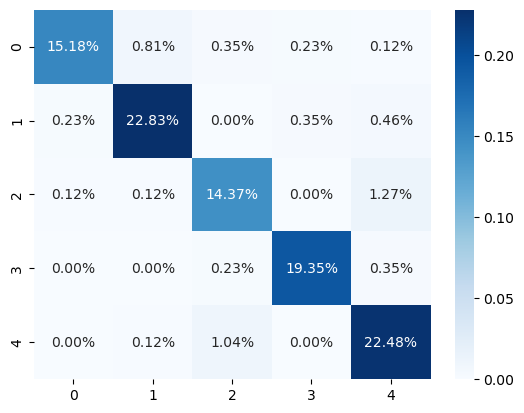

In [23]:
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
#target_names = ['Normal','Glocoman']
print(classification_report(test_label, y_pred, target_names=target_names))

sns.heatmap(cm/np.sum(cm), annot = True, fmt='.2%', cmap = "Blues")

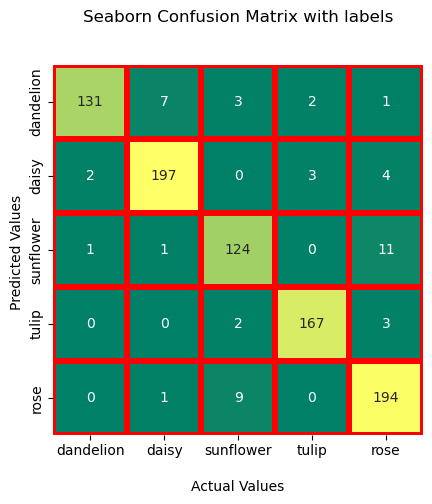

In [24]:
ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');

In [25]:
print("    Test Loss: {:.5f}".format(y_pred[0]))
print("Test Accuracy: {:.2f}%".format(y_pred[1]))

    Test Loss: 4.00000
Test Accuracy: 1.00%


In [26]:
hist.history

{'loss': [1.182539463043213,
  0.5887640118598938,
  0.3145742118358612,
  0.19001908600330353,
  0.11449108272790909,
  0.0825190469622612,
  0.06059534102678299,
  0.04463783651590347,
  0.03602181002497673,
  0.02826039120554924,
  0.021640362218022346],
 'accuracy': [0.5781702399253845,
  0.8604516386985779,
  0.9363057613372803,
  0.9667052626609802,
  0.9791545867919922,
  0.986392617225647,
  0.9895772933959961,
  0.9924724698066711,
  0.9930515289306641,
  0.994788646697998,
  0.996525764465332],
 'val_loss': [0.6074104905128479,
  0.31312185525894165,
  0.21662355959415436,
  0.18262897431850433,
  0.1722363531589508,
  0.17112469673156738,
  0.17941123247146606,
  0.1819002777338028,
  0.17977212369441986,
  0.1790628582239151,
  0.18890516459941864],
 'val_accuracy': [0.8945538997650146,
  0.9293163418769836,
  0.9339513182640076,
  0.9374275803565979,
  0.9455388188362122,
  0.9420625567436218,
  0.9455388188362122,
  0.9478563070297241,
  0.9466975927352905,
  0.9571263194